# Initial model 
$\lambda_{insulation}=0.027$ W/(m·K)

In the initial model, the insulation used has a conductivity of 0.027 W/(m·K). This is the order of magnitude of insulation commonly used, such as polyurethane. 
We will study the influence of an increase in the thermal conductivity of the insulation. It determines the material's ability to conduct heat.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

l = 3               # m length of the cubic room
Sg = l**2           # m² surface area of the glass wall
Sc = Si = 5 * Sg    # m² surface area of concrete & insulation of the 5 walls

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

concrete = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': 5 * l**2}            # m²

insulation = {'Conductivity': 0.027,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': 5 * l**2}          # m²

glass = {'Conductivity': 1.4,               # W/(m·K)
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 0.04,                     # m
         'Surface': l**2}                   # m²

wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass},
                              orient='index')
wall

# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

# convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

## Long wave radiation
# view factor wall-glass
Fwg = glass['Surface'] / concrete['Surface']

T_int = 273.15 + np.array([0, 40])
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For 0°C < (T/K - 273.15)°C < 40°C, 4σT³/[W/(m²·K)] ∈ {coeff}')

T_int = 273.15 + np.array([10, 30])
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For 10°C < (T/K - 273.15)°C < 30°C, 4σT³/[W/(m²·K)] ∈ {coeff}')

T_int = 273.15 + 20
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For (T/K - 273.15)°C = 20°C, 4σT³ = {4 * σ * T_int**3:.1f} W/(m²·K)')

# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

## Advection

# ventilation flow rate
Va = l**3                   # m³, volume of air
ACH = 1                     # 1/h, air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

# P-controler gain
# Kp = 1e4            # almost perfect controller Kp -> ∞
# Kp = 1e-3           # no controller Kp -> 0
Kp = 0

## Conductances in series and/or parallel
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg.loc['h', 'out'] + 1 / (2 * G_cd['Glass'])))

## Thermal capacities
# Walls
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])
# Air
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])

## Matrices
# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7']

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11']

A = np.zeros([12, 8])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6

pd.DataFrame(A, index=q, columns=θ)

G = np.array(np.hstack(
    [Gw['out'],
     2 * G_cd['Layer_out'], 2 * G_cd['Layer_out'],
     2 * G_cd['Layer_in'], 2 * G_cd['Layer_in'],
     GLW,
     Gw['in'],
     Gg['in'],
     Ggs,
     2 * G_cd['Glass'],
     Gv,
     Kp]))

# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

neglect_air_glass = False

if neglect_air_glass:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  0, 0])
else:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  C['Air'], C['Glass']])

# pd.set_option("display.precision", 3)
pd.DataFrame(C, index=θ)

b = pd.Series(['To', 0, 0, 0, 0, 0, 0, 0, 'To', 0, 'To', 'Ti_sp'],
              index=q)

f = pd.Series(['Φo', 0, 0, 0, 'Φi', 0, 'Qa', 'Φa'],
              index=θ)

y = np.zeros(8)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

# TC['G']['q11'] = 1e3  # Kp -> ∞, almost perfect controller
TC['G']['q11'] = 0      # Kp -> 0, no controller (free-floating)

[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

bss = np.zeros(12)        # temperature sources
bss[[0, 8, 10]] = 10      # outdoor temperature
bss[[11]] = 20            # indoor set-point temperature

fss = np.zeros(8)         # flow-rate sources

A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])
print(f'uss = {uss}')

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values)
print(f'yss = {yss:.2f} °C')

print(f'Error between DAE and state-space: {abs(θss[6] - yss):.2e} °C')

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
λ = np.sort(λ)

print('Time constants:') 
print([f'{T:.2f} s' for T in -1 / λ])

print('\n2 x Time constants:') 
print([f'{T:.2f} s' for T in -2 / λ])

dtmax1 = 2 * min(-1. / λ)
print(f'\nMaximum time step: {dtmax1:.2f} s = {dtmax1 / 60:.2f} min')

# time step
if dtmax1 >= 60:
    dt1 = np.floor(dtmax1 / 60) * 60  # round to minutes
    print(f'dt = {dt1} s = {dt1 / 60:.0f} min')
elif dtmax1 >= 10:
    dt1 = np.floor(dtmax1 / 10) * 10  # round to tens of seconds
    print(f'dt = {dt1} s')
else:
    dt1 = np.floor(dtmax1)            # round to seconds
    print(f'dt = {dt1} s')
    
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle1 = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle1:.0f} s = \
{t_settle1 / 60:.1f} min = \
{t_settle1 / (3600):.2f} h = \
{t_settle1 / (3600 * 24):.2f} days')

### Steady state

controller = False
explicit_Euler = False
imposed_time_step = False
Δt = 3600    # s, imposed time step 

print('Matrices and vectors for thermal circuit from Figure 1') 
#pd.read_csv('./toy_model/TC_0.csv')

# MODEL
# =====
# Thermal circuit
#TC = dm4bem.file2TC('./toy_model/TC.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0, i.e. Kp -> 0, no controller (free-floating)
if controller:
    TC['G']['q11'] = 1e3        # Kp -> ∞, almost perfect controller
    
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

bss = np.zeros(12)        # temperature sources b for steady state
bss[[0, 8, 10]] = 10      # outdoor temperature
bss[[11]] = 20            # indoor set-point temperature

fss = np.zeros(8)         # flow-rate sources f for steady state

A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

bss = np.zeros(12)        # temperature sources b for steady state

fss = np.zeros(8)         # flow-rate sources f for steady state
fss[[6]] = 1000

θssQ = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θssQ = {np.around(θssQ, 2)} °C')

bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values)
print(f'yss = {yss:.2f} °C')
print(f'Error between DAE and state-space: {abs(θss[6] - yss):.2e} °C')

bT = np.array([0, 0, 0, 0])         # [To, To, To, Tisp]
fQ = np.array([0, 0, 1000, 0])      # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yssQ = (-Cs @ inv_As @ Bs + Ds) @ uss

yssQ = float(yssQ.values)
print(f'yssQ = {yssQ:.2f} °C')
print(f'Error between DAE and state-space: {abs(θssQ[6] - yssQ):.2e} °C')

# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

# time step
if imposed_time_step:
    dt1 = Δt
else:
    dtmax1 = 2 * min(-1. / λ)    # max time step for Euler explicit stability
    dt1 = dm4bem.round_time(dtmax1)
dm4bem.print_rounded_time('dt', dt1)

# settling time
t_settle1 = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle1)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle1 / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt1))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt1)}S")

To = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# Get inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

# Initial conditions
θ0 = 0                      # initial temperatures
θ_exp = pd.DataFrame(index=u.index)
θ_exp[As.columns] = θ0      # fill θ with initial values θ0
θ_imp = θ_exp


I = np.eye(As.shape[0])     # identity matrix

for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt1 * As)\
        @ θ_exp.iloc[k] + dt1 * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt1 * As)\
        @ (θ_imp.iloc[k] + dt1 * Bs @ u.iloc[k])
        
# outputs
y_exp1 = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp1 = (Cs @ θ_imp.T + Ds @  u.T).T




# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt1))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt1)}S")

To = 0 * np.ones(n)         # outdoor temperature
Ti_sp =  0 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Φo = Φi = Φa                # solar radiation
Qa = 1000 * np.ones(n)      # auxiliary heat sources
data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# Get inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)



σ = 5.67e-08 W/(m²⋅K⁴)
For 0°C < (T/K - 273.15)°C < 40°C, 4σT³/[W/(m²·K)] ∈ [4.6 7. ]
For 10°C < (T/K - 273.15)°C < 30°C, 4σT³/[W/(m²·K)] ∈ [5.1 6.3]
For (T/K - 273.15)°C = 20°C, 4σT³ = 5.7 W/(m²·K)
θss = [10. 10. 10. 10. 10. 10. 10. 10.] °C
uss = [10 10 10 20  0  0  0  0]
yss = 10.00 °C
Error between DAE and state-space: 5.33e-15 °C
Time constants:
['249.30 s', '4093.20 s', '6729.11 s', '44033.06 s']

2 x Time constants:
['498.60 s', '8186.41 s', '13458.22 s', '88066.12 s']

Maximum time step: 498.60 s = 8.31 min
dt = 480.0 s = 8 min
4 * Time constants: 
 [   996  16372  26916 176132] s 

Settling time: 176132 s = 2935.5 min = 48.93 h = 2.04 days
Matrices and vectors for thermal circuit from Figure 1
θss = [10. 10. 10. 10. 10. 10. 10. 10.] °C
θssQ = [ 0.14  0.39  0.65  5.88 11.12  5.57 12.26  4.41] °C
uss = [10 10 10 20  0  0  0  0]
yss = 10.00 °C
Error between DAE and state-space: 5.33e-15 °C
yssQ = 12.26 °C
Error between DAE and state-space: 1.78e-15 °C
dt = 300 s = 5.0 min
t_settle

# New model

$\lambda_{insulation}=0.27$ W/(m·K)

We multiply the value of the insulation's conductivity by 10 : "insulation = {'Conductivity': 0.27,# W/(m·K)"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

l = 3               # m length of the cubic room
Sg = l**2           # m² surface area of the glass wall
Sc = Si = 5 * Sg    # m² surface area of concrete & insulation of the 5 walls

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

concrete = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': 5 * l**2}            # m²

# we change the value of the conductivity 
insulation = {'Conductivity': 0.27,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': 5 * l**2}          # m²

glass = {'Conductivity': 1.4,               # W/(m·K)
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 0.04,                     # m
         'Surface': l**2}                   # m²

wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass},
                              orient='index')
wall

# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

# convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

## Long wave radiation
# view factor wall-glass
Fwg = glass['Surface'] / concrete['Surface']

T_int = 273.15 + np.array([0, 40])
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For 0°C < (T/K - 273.15)°C < 40°C, 4σT³/[W/(m²·K)] ∈ {coeff}')

T_int = 273.15 + np.array([10, 30])
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For 10°C < (T/K - 273.15)°C < 30°C, 4σT³/[W/(m²·K)] ∈ {coeff}')

T_int = 273.15 + 20
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For (T/K - 273.15)°C = 20°C, 4σT³ = {4 * σ * T_int**3:.1f} W/(m²·K)')

# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

## Advection

# ventilation flow rate
Va = l**3                   # m³, volume of air
ACH = 1                     # 1/h, air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

# P-controler gain
# Kp = 1e4            # almost perfect controller Kp -> ∞
# Kp = 1e-3           # no controller Kp -> 0
Kp = 0

## Conductances in series and/or parallel
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg.loc['h', 'out'] + 1 / (2 * G_cd['Glass'])))

## Thermal capacities
# Walls
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])
# Air
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])

## Matrices
# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7']

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11']

A = np.zeros([12, 8])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6

pd.DataFrame(A, index=q, columns=θ)

G = np.array(np.hstack(
    [Gw['out'],
     2 * G_cd['Layer_out'], 2 * G_cd['Layer_out'],
     2 * G_cd['Layer_in'], 2 * G_cd['Layer_in'],
     GLW,
     Gw['in'],
     Gg['in'],
     Ggs,
     2 * G_cd['Glass'],
     Gv,
     Kp]))

# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

neglect_air_glass = False

if neglect_air_glass:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  0, 0])
else:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  C['Air'], C['Glass']])

# pd.set_option("display.precision", 3)
pd.DataFrame(C, index=θ)

b = pd.Series(['To', 0, 0, 0, 0, 0, 0, 0, 'To', 0, 'To', 'Ti_sp'],
              index=q)

f = pd.Series(['Φo', 0, 0, 0, 'Φi', 0, 'Qa', 'Φa'],
              index=θ)

y = np.zeros(8)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

# TC['G']['q11'] = 1e3  # Kp -> ∞, almost perfect controller
TC['G']['q11'] = 0      # Kp -> 0, no controller (free-floating)

[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

bss = np.zeros(12)        # temperature sources
bss[[0, 8, 10]] = 10      # outdoor temperature
bss[[11]] = 20            # indoor set-point temperature

fss = np.zeros(8)         # flow-rate sources

A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])
print(f'uss = {uss}')

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values)
print(f'yss = {yss:.2f} °C')

print(f'Error between DAE and state-space: {abs(θss[6] - yss):.2e} °C')

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
λ = np.sort(λ)

print('Time constants:') 
print([f'{T:.2f} s' for T in -1 / λ])

print('\n2 x Time constants:') 
print([f'{T:.2f} s' for T in -2 / λ])

dtmax = 2 * min(-1. / λ)
print(f'\nMaximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

# time step
if dtmax >= 60:
    dt = np.floor(dtmax / 60) * 60  # round to minutes
    print(f'dt = {dt} s = {dt / 60:.0f} min')
elif dtmax >= 10:
    dt = np.floor(dtmax / 10) * 10  # round to tens of seconds
    print(f'dt = {dt} s')
else:
    dt = np.floor(dtmax)            # round to seconds
    print(f'dt = {dt} s')
    
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

### Steady state

controller = False
explicit_Euler = False
imposed_time_step = False
Δt = 3600    # s, imposed time step 

print('Matrices and vectors for thermal circuit from Figure 1') 
#pd.read_csv('./toy_model/TC_0.csv')

# MODEL
# =====
# Thermal circuit
#TC = dm4bem.file2TC('./toy_model/TC.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0, i.e. Kp -> 0, no controller (free-floating)
if controller:
    TC['G']['q11'] = 1e3        # Kp -> ∞, almost perfect controller
    
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

bss = np.zeros(12)        # temperature sources b for steady state
bss[[0, 8, 10]] = 10      # outdoor temperature
bss[[11]] = 20            # indoor set-point temperature

fss = np.zeros(8)         # flow-rate sources f for steady state

A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

bss = np.zeros(12)        # temperature sources b for steady state

fss = np.zeros(8)         # flow-rate sources f for steady state
fss[[6]] = 1000

θssQ = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θssQ = {np.around(θssQ, 2)} °C')

bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values)
print(f'yss = {yss:.2f} °C')
print(f'Error between DAE and state-space: {abs(θss[6] - yss):.2e} °C')

bT = np.array([0, 0, 0, 0])         # [To, To, To, Tisp]
fQ = np.array([0, 0, 1000, 0])      # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yssQ = (-Cs @ inv_As @ Bs + Ds) @ uss

yssQ = float(yssQ.values)
print(f'yssQ = {yssQ:.2f} °C')
print(f'Error between DAE and state-space: {abs(θssQ[6] - yssQ):.2e} °C')

# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

# time step
if imposed_time_step:
    dt = Δt
else:
    dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
    dt = dm4bem.round_time(dtmax)
dm4bem.print_rounded_time('dt', dt)

# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}S")

To = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# Get inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

# Initial conditions
θ0 = 0                      # initial temperatures
θ_exp = pd.DataFrame(index=u.index)
θ_exp[As.columns] = θ0      # fill θ with initial values θ0
θ_imp = θ_exp


I = np.eye(As.shape[0])     # identity matrix

for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])
        
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T


σ = 5.67e-08 W/(m²⋅K⁴)
For 0°C < (T/K - 273.15)°C < 40°C, 4σT³/[W/(m²·K)] ∈ [4.6 7. ]
For 10°C < (T/K - 273.15)°C < 30°C, 4σT³/[W/(m²·K)] ∈ [5.1 6.3]
For (T/K - 273.15)°C = 20°C, 4σT³ = 5.7 W/(m²·K)
θss = [10. 10. 10. 10. 10. 10. 10. 10.] °C
uss = [10 10 10 20  0  0  0  0]
yss = 10.00 °C
Error between DAE and state-space: 7.11e-15 °C
Time constants:
['123.44 s', '891.48 s', '5044.73 s', '41314.74 s']

2 x Time constants:
['246.88 s', '1782.96 s', '10089.47 s', '82629.49 s']

Maximum time step: 246.88 s = 4.11 min
dt = 240.0 s = 4 min
4 * Time constants: 
 [   492   3564  20176 165256] s 

Settling time: 165259 s = 2754.3 min = 45.91 h = 1.91 days
Matrices and vectors for thermal circuit from Figure 1
θss = [10. 10. 10. 10. 10. 10. 10. 10.] °C
θssQ = [0.46 1.3  2.13 3.85 5.57 3.13 7.33 2.48] °C
uss = [10 10 10 20  0  0  0  0]
yss = 10.00 °C
Error between DAE and state-space: 7.11e-15 °C
yssQ = 7.33 °C
Error between DAE and state-space: 2.66e-15 °C
dt = 240 s = 4.0 min
t_settle = 165258 

# Comparaison of time step and settling time

The settling time is the duration required for a system to reach a steady state. The indoor temperature achieved after the settling time is almost equal to the temperature reached in steady-state.

In [5]:
Mod1={'dt (s)':dt1,'Settling time (s)':t_settle1}
Mod2={'dt (s)':dt,'Settling time (s)':t_settle}
pd.DataFrame.from_dict({'$\\lambda$=0.027 W/(m·K)':Mod1,
                        '$\\lambda$=0.27 W/(m·K)':Mod2},orient='index')

,dt (s),Settling time (s)
$\lambda$=0.027 W/(m·K),300.0,176132.233808
$\lambda$=0.27 W/(m·K),240.0,165258.975903


We observe that an increase in the conductivity of insulation leads to a faster response to outdoor temperature changes (3h less). An insulation with a higher conductivity allows heat to transfer more quickly through the material.

Concerning the value of dt, it is higher when the settling time is higher. When more calculations are required, a larger time step is used to facilitate calculations.

# Comparaison of step response to outdoor temperature
A step response to outdoor temperature refers to the behavior of the system when there is a sudden change in the outdoor temperature. It describes how quickly and how much the indoor temperature changes in response to the change in outdoor temperature.

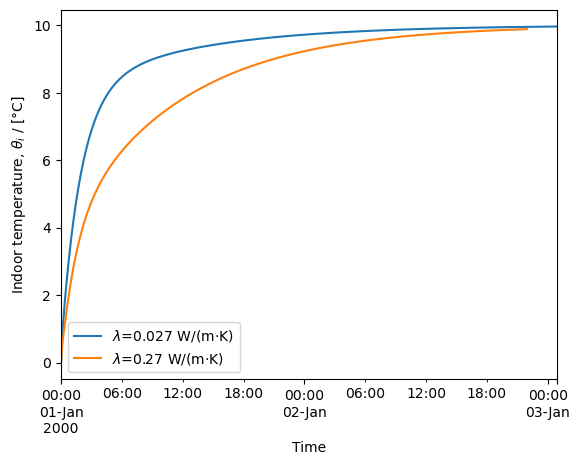

In [4]:
# plot results
y1 = pd.concat([y_exp1, y_imp1], axis=1, keys=['Explicit', 'Implicit'])
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y1.columns = y1.columns.get_level_values(0)
y.columns = y.columns.get_level_values(0)

ax = y_imp1.plot()
y_imp.plot(ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / [°C]')
ax.legend(['$\\lambda$=0.027 W/(m·K)','$\\lambda$=0.27 W/(m·K)'])
plt.show()


The steady-state is reached more rapidly with a higher conductivity but the indoor temperature increases more slowly.  